# Open Dataset and visualize images

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Dataset size: 52224
zv 2608.08251953125, rs: 2626.713134765625
zv 2782.454833984375, rs: 2551.3671875
zv 2610.4521484375, rs: 2381.88037109375
zv 2704.765869140625, rs: 2492.60205078125
zv 2698.8681640625, rs: 2489.808349609375
zv 2764.678955078125, rs: 2668.211181640625
zv 2783.47216796875, rs: 2569.34033203125
zv 2798.9697265625, rs: 2751.315185546875
zv 2728.2705078125, rs: 2682.25341796875
zv 2792.6630859375, rs: 2723.929443359375


<Figure size 432x288 with 0 Axes>

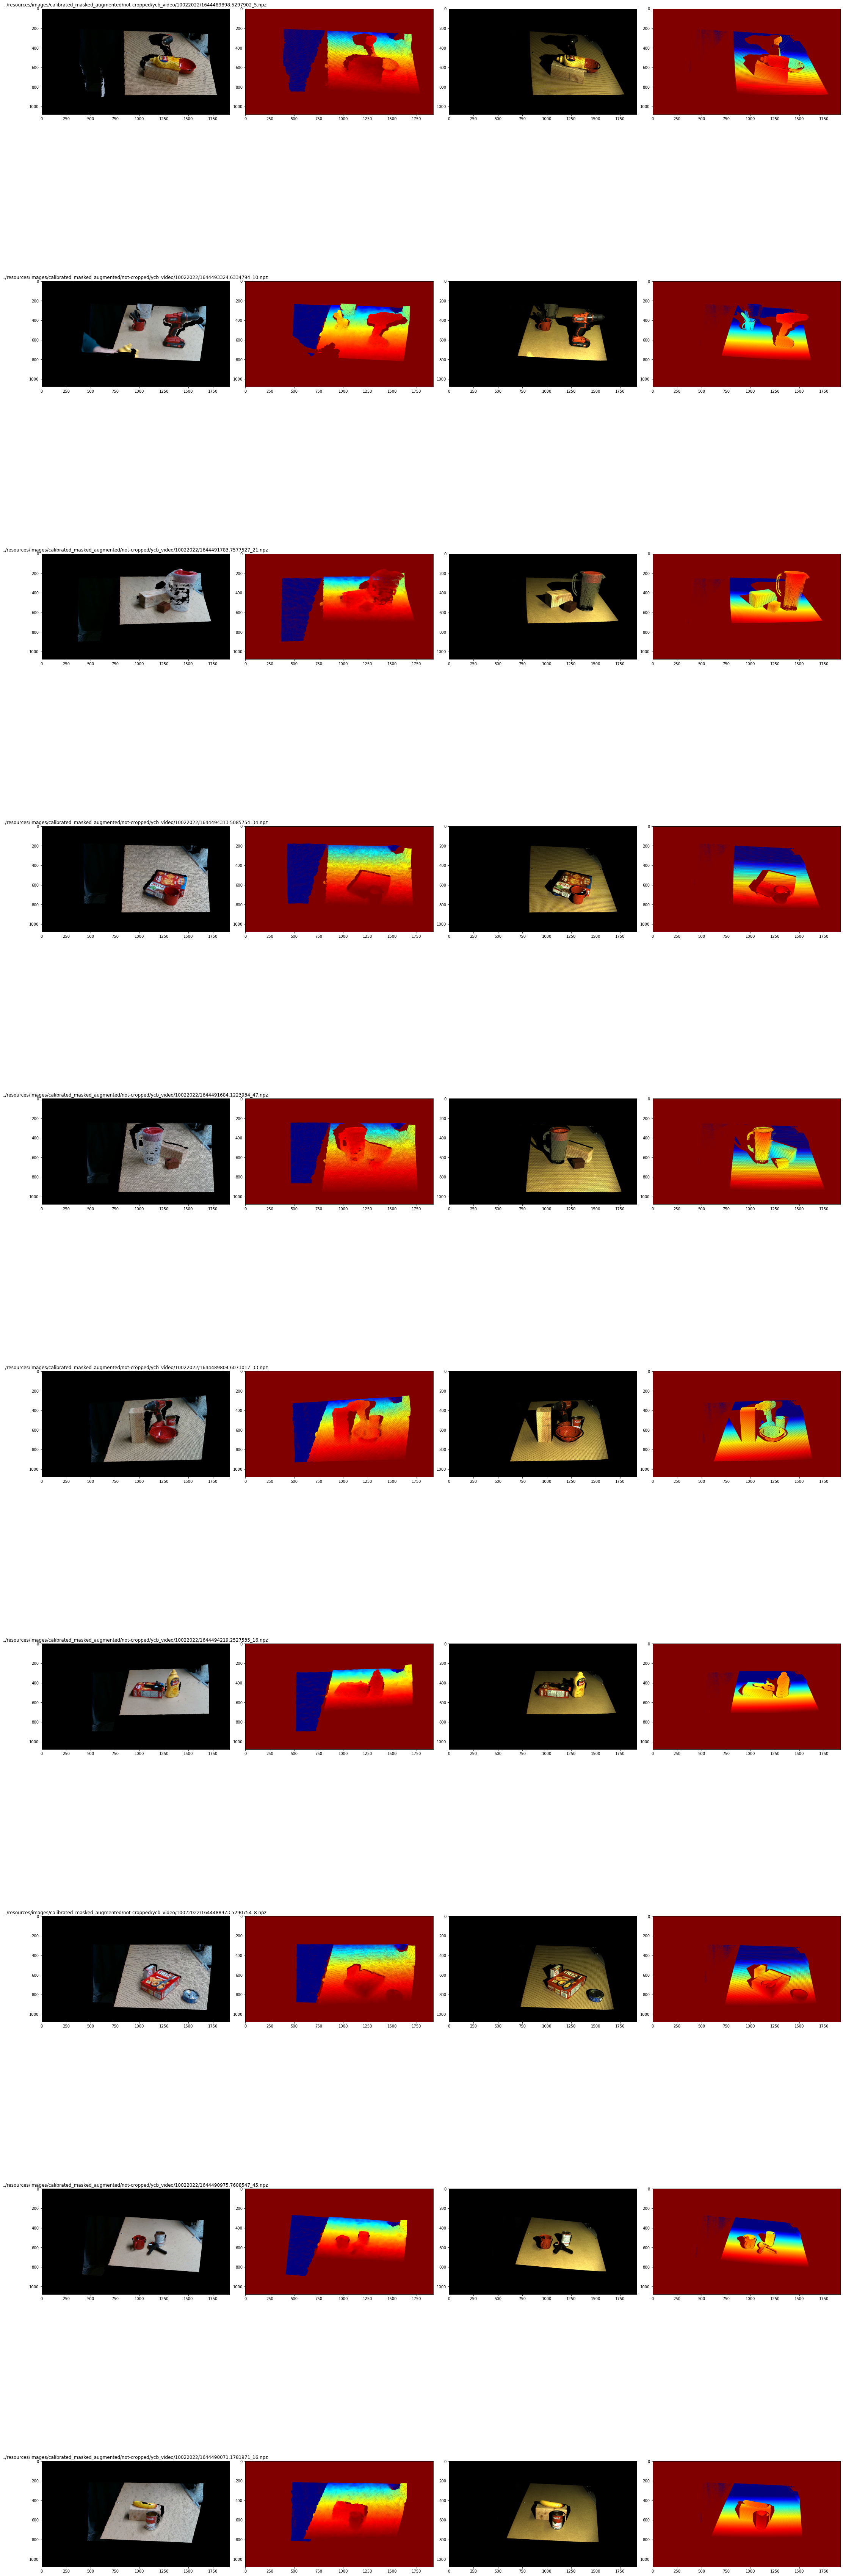

In [1]:
import os
os.sys.path.append("../src")

from dataset.dataset_interface import DatasetInterface
from matplotlib import pyplot as plt
from pathlib import Path
from utils.visualization_utils import to_rgb, visualize_depth
from utils.transformation_utils import imgs_to_pcd, rs_ci, zv_ci
import numpy as np
import open3d as o3d
import random

dir_to_visualize = Path("../resources/images/calibrated_masked_augmented")
pcd_first = False

files = DatasetInterface.get_paths_in_dir(dir_to_visualize, recursive=True)
print(f"Dataset size: {len(files)}")

random.shuffle(files)
files = files[:10]

plt.figure()
f, axarr = plt.subplots(len(files), 4, figsize=(30, 10 * len(files)))
f.tight_layout()

for i, file in enumerate(files):
    rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(file)
    print(f"zv {np.nanmax(zv_depth)}, rs: {np.nanmax(rs_depth)}")
    if i == 0 and pcd_first:
        rs_pcd = imgs_to_pcd(rs_rgb, rs_depth, rs_ci)
        # zv_pcd = imgs_to_pcd(zv_rgb, zv_depth, rs_ci)
        zv_pcd = imgs_to_pcd(zv_rgb, zv_depth, zv_ci)
        o3d.visualization.draw_geometries([rs_pcd, zv_pcd])

    axarr[i][0].set_title(file)
    axarr[i][0].imshow(to_rgb(rs_rgb))
    axarr[i][1].imshow(visualize_depth(rs_depth))
    axarr[i][2].imshow(to_rgb(zv_rgb))
    axarr[i][3].imshow(visualize_depth(zv_depth))

In [ ]:
from dataset.dataset_interface import DatasetInterface
from matplotlib import pyplot as plt
from pathlib import Path
from utils.visualization_utils import to_rgb, visualize_depth
import cv2

dir_to_visualize = Path("../../resources/images/calibrated")

dataset_interface = DatasetInterface(dir_to_visualize)
print(f"Dataset size: {len(dataset_interface)}")

plt.figure()
f, axarr = plt.subplots(len(dataset_interface), 1, figsize=(30, 80))
f.tight_layout()

for i, (rs_rgb, rs_depth, zv_rgb, zv_depth) in enumerate(dataset_interface):
    axarr[i].imshow(to_rgb(cv2.addWeighted(rs_rgb, 0.5, zv_rgb, 0.5, 0)))

# Visualize Dataset RGB Images

In [ ]:
from dataset.dataset_interface import DatasetInterface
from matplotlib import pyplot as plt
from pathlib import Path
from utils.visualization_utils import to_rgb, visualize_depth
from utils.transformation_utils import imgs_to_pcd, rs_ci, zv_ci
import numpy as np
import open3d as o3d
import random

dir_to_visualize = Path("../../resources/images/calibrated_masked_augmented/cropped/ycb_video")
files = list(dir_to_visualize.rglob("*.npz"))

print(f"Dataset size: {len(files)}")

random.shuffle(files)
idx = 0

In [ ]:
import math
objects = 50
rows = math.ceil(objects / 4)
plt.figure()
f, axarr = plt.subplots(rows, 4, figsize=(30, 6 * rows))

f.tight_layout()

print(f"Start index {idx}")
for i in range(objects):
    file = files[i + idx]
    column = i % 4
    row = (i - column) // 4
    rs_rgb, rs_depth, zv_rgb, zv_depth, _ = DatasetInterface.load(file)
    axarr[row][column].set_title(file.name)
    axarr[row][column].imshow(zv_rgb)

idx += i + 1

# Visualize Dataset Preprocessing

In [1]:
from dataset.dataset_interface import DatasetInterface
from pathlib import Path
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
import numpy as np
from utils.visualization_utils import visualize_depth, visualize_mask, to_rgb
from utils.transformation_utils import unnormalize_depth

dir = Path("../resources/images/calibrated_masked_augmented/not-cropped/ycb_video")
dataset_config = BasicDataset.Config(scale=1, add_nan_mask_to_input=True,
add_region_mask_to_input=True, normalize_depths=False, normalize_depths_min=None, normalize_depths_max=None)
dataset = BasicDataset(dir, config=dataset_config)
set = dataset[np.random.randint(len(dataset), size=(1,)).item()]
image = set['image'].numpy()
mask = set['label'].numpy()
nan_mask = set['nan-mask'].numpy().transpose((1, 2, 0))
region_mask = set['region-mask'].numpy().transpose((1, 2, 0)).astype(np.uint8)

image = image.transpose((1, 2, 0))
rgb_image = image[..., :3]
depth_image = image[..., 3].squeeze()
depth_mask = mask.transpose((1, 2, 0)).squeeze()

if dataset_config.normalize_depths:
    depth_image = unnormalize_depth(depth_image, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)
    depth_mask = unnormalize_depth(depth_mask, dataset_config.normalize_depths_min, dataset_config.normalize_depths_max)

mask = np.logical_and(nan_mask, region_mask).squeeze()
depth_image = np.where(mask, depth_image, np.nan)
depth_mask = np.where(mask, depth_mask, np.nan)

_, axarr = plt.subplots(1, 5, figsize=(30, 10))
axarr[0].axis('off')
axarr[0].title.set_text("rgb input")
axarr[0].imshow(to_rgb(rgb_image))
axarr[1].axis('off')
axarr[1].title.set_text("depth input")
axarr[1].imshow(visualize_depth(depth_image))
axarr[2].axis('off')
axarr[2].title.set_text("depth label")
axarr[2].imshow(visualize_depth(depth_mask))
axarr[3].axis('off')
axarr[3].title.set_text("nan mask")
axarr[3].imshow(visualize_mask(nan_mask))
axarr[4].axis('off')
axarr[4].title.set_text("region mask")
axarr[4].imshow(visualize_depth(region_mask))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-02-19 13:22:52,439 - data_loading - Creating dataset with size 52224


ValueError: operands could not be broadcast together with shapes (1,1080,1920) (1080,1920,1) 

# Write Dataset Examples to disk

In [ ]:
from dataset.dataset_interface import DatasetInterface
from utils.visualization_utils import visualize_depth
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2

dataset = DatasetInterface(Path("../../resources/images/uncalibrated/dataset_4"))
idx = np.random.randint(len(dataset))
idx = 39
rs_rgb, rs_depth, zv_rgb, zv_depth = dataset[idx]
print(idx, dataset.data_file_paths[idx])

rs_depth = visualize_depth(rs_depth)
zv_depth = visualize_depth(zv_depth)

_, axarr = plt.subplots(1, 4, figsize=(40, 10))
axarr[0].imshow(cv2.cvtColor(rs_rgb, cv2.COLOR_BGR2RGB))
axarr[1].imshow(rs_depth)
axarr[2].imshow(cv2.cvtColor(zv_rgb, cv2.COLOR_BGR2RGB))
axarr[3].imshow(zv_depth)

cv2.imwrite("rs_rgb_plane.png", rs_rgb)
cv2.imwrite("rs_depth_plane.png", rs_depth)
cv2.imwrite("zv_rgb_plane.png", zv_rgb)
cv2.imwrite("zv_depth_plane.png", zv_depth)

In [ ]:
# show process
from dataset.dataset_interface import DatasetInterface
from utils.visualization_utils import to_rgb
from pathlib import Path
from matplotlib import pyplot as plt

raw_dir = Path("../resources/images/raw")
calibrated_dir = Path("../resources/images/calibrated_masked/cropped")

image = "ycb_video/10022022/1644488349.8732007.npz"

raw_rs_rgb, _, raw_zv_rgb, _, _, = DatasetInterface.load(raw_dir / image)
calibrated_rs_rgb, _, calibrated_zv_rgb, _, _, = DatasetInterface.load(calibrated_dir / image)

fig = plt.figure(constrained_layout=True)
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)

subfigs[0].suptitle(f'raw images')
axs_0 = subfigs[0].subplots(nrows=1, ncols=2)
axs_0[0].axis('off')
axs_0[0].imshow(to_rgb(raw_rs_rgb))
axs_0[0].set_title("LQ")
axs_0[1].axis('off')
axs_0[1].imshow(to_rgb(raw_zv_rgb))
axs_0[1].set_title("HQ")

subfigs[1].suptitle(f'calibrated images')
axs_1 = subfigs[1].subplots(nrows=1, ncols=2)
axs_1[0].axis('off')
axs_1[0].imshow(to_rgb(calibrated_rs_rgb))
axs_1[0].set_title("LQ")
axs_1[1].axis('off')
axs_1[1].imshow(to_rgb(calibrated_zv_rgb))
axs_1[1].set_title("HQ")
plt.savefig("output.png")

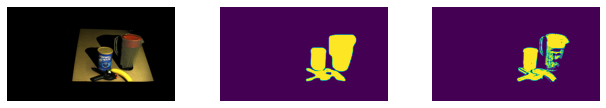

In [38]:
from dataset.dataset_interface import DatasetInterface
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from utils.visualization_utils import visualize_mask, to_rgb

_, _, _, _, mask_1 = DatasetInterface.load(Path("../resources/images/_old/calibrated_masked_maskrcnn/not-cropped/ycb_video/10022022/1644488176.9169168.npz"))
_, _, zv_rgb, zv_depth, mask_2 = DatasetInterface.load(Path("../resources/images/calibrated_masked/not-cropped/ycb_video/10022022/1644488176.9169168.npz"))

# mask_2 = np.where(np.isnan(zv_depth), True, mask_2)

_, ax = plt.subplots(1, 3, figsize=(9, 10))
plt.tight_layout()
ax[0].imshow(to_rgb(zv_rgb))
ax[0].axis('off')
ax[1].imshow(np.sum(mask_1, axis=2) > 0)
ax[1].axis('off')
ax[2].imshow(mask_2)
ax[2].axis('off')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.01, hspace=0.01)
plt.savefig("mask_result.png")